# Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error

# Load Dataset

In [ ]:
df = pd.read_csv('BTC-USD.csv')
df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
df

,Date,Open,High,Low,Close,Volume
0,2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800
1,2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200
2,2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700
3,2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600
4,2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100
...,...,...,...,...,...,...
3815,2025-02-26 00:00:00+00:00,88638.890625,89286.250000,82131.898438,84347.023438,64597492134
3816,2025-02-27 00:00:00+00:00,84076.859375,87000.781250,83144.960938,84704.226562,52659591954
3817,2025-02-28 00:00:00+00:00,84705.625000,85036.320312,78248.914062,84373.007812,83610570576
3818,2025-03-01 00:00:00+00:00,84373.867188,86522.304688,83794.234375,86031.914062,29190628396


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3820 entries, 0 to 3819
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3820 non-null   object 
 1   Open    3820 non-null   float64
 2   High    3820 non-null   float64
 3   Low     3820 non-null   float64
 4   Close   3820 non-null   float64
 5   Volume  3820 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 179.2+ KB


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Bitcoin Price Candlestick Chart Visualization

In [5]:
fig = go.Figure(data=[go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    increasing_line_color='green',
    decreasing_line_color='red',
    hovertext=df.index.strftime('%d %b %Y') + '<br>Open: ' + df['Open'].astype(str) +
              '<br>High: ' + df['High'].astype(str) + '<br>Low: ' + df['Low'].astype(str) +
              '<br>Close: ' + df['Close'].astype(str),
    hoverinfo='text'
)])

fig.update_layout(
    title="Bitcoin Price Candlestick Chart",
    xaxis_title="Date & Year",
    yaxis_title="Price (USD)",
    xaxis_rangeslider_visible=False,
    xaxis=dict(
        tickformat="%Y",
        dtick="M12"
    ),
    yaxis=dict(
        tick0=0,
        dtick=10000
    ),
    width=900,
    height=450
)

fig.show()


# Preprocessing

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

In [7]:
data_scaled

array([[0.00263505],
       [0.00232463],
       [0.00204489],
       ...,
       [0.79453019],
       [0.81018495],
       [0.8877218 ]])

In [8]:
def create_sequences(df, seq_length):
    sequences, labels = [], []
    for i in range(len(df) - seq_length):
        sequences.append(df[i:i + seq_length])
        labels.append(df[i + seq_length, 0])
    return np.array(sequences), np.array(labels)

In [9]:
seq_length = 30

train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Training using LSTM

In [10]:
model = Sequential()

# First Layer LSTM
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Second Layer LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dense Layer
model.add(Dense(units=25))
model.add(Dense(units=1))

In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=200, batch_size=84, validation_data=(X_test, y_test))

Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0120 - val_loss: 0.0028
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 9.1006e-04 - val_loss: 0.0012
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 6.9253e-04 - val_loss: 0.0012
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 6.5512e-04 - val_loss: 9.0052e-04
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 5.4999e-04 - val_loss: 9.1694e-04
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 6.9132e-04 - val_loss: 0.0019
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 4.0530e-04 - val_loss: 9.1342e-04
Epoch 8/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 5.2261e-04 - val_loss: 0.0016
Epoch 9/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 4.7730e-04 - val_loss: 0.0028
Epoch 10/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 4.4612e-04 - val_loss: 0.0027
Epoch 11/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 4.3216e-04 - val_loss: 0.0021


# Model Evaluation

In [12]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
mse = mean_squared_error(y_test_scaled, predictions)
print('Mean Squared Error:', mse)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Mean Squared Error: 4027614.8262668047


In [13]:
mape = np.mean(np.abs((y_test_scaled - predictions) / y_test_scaled)) * 100
print('Mean Absolute Percentage Error (MAPE):', mape, '%')

Mean Absolute Percentage Error (MAPE): 2.8852958832415165 %


# Actual Price vs Predicted Price

In [14]:
last_day = df['Close'][-seq_length:].values.reshape(-1, 1)
last_day_scaled = scaler.transform(last_day)

X_predict = []
X_predict.append(last_day_scaled)
X_predict = np.array(X_predict)
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

predicted_price = model.predict(X_predict)
predicted_price = scaler.inverse_transform(predicted_price)

print('Predicted Price:', predicted_price[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Price: 94409.945


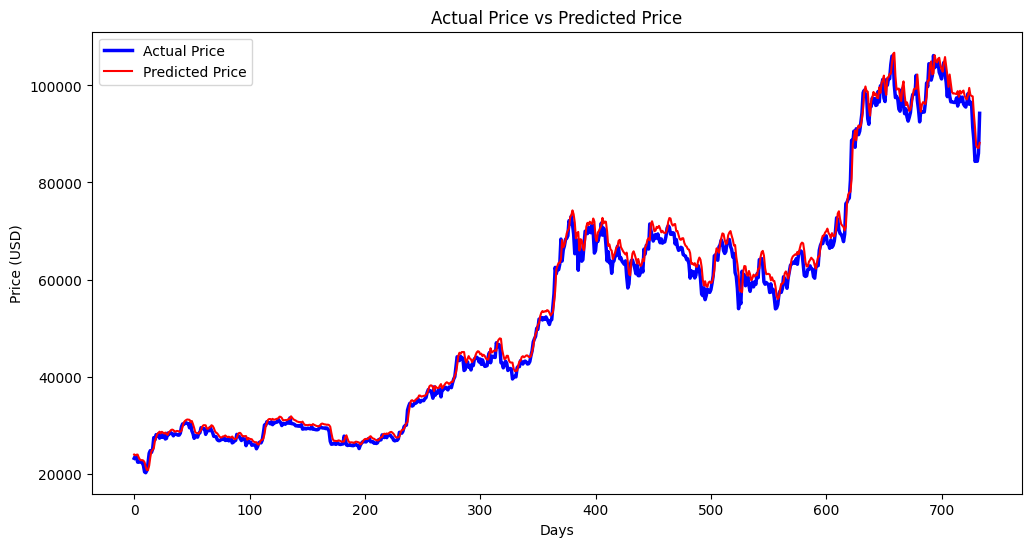

In [15]:
plt.figure(figsize=(12, 6))

plt.plot(y_test_scaled, label='Actual Price', color='blue', linewidth=2.5)
plt.plot(predictions, label='Predicted Price', color='red', linewidth=1.5)

plt.title('Actual Price vs Predicted Price')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()

plt.show()

# Future Price Predictions

In [16]:
future_days = 30

last_seq_days = df['Close'][-seq_length:].values.reshape(-1, 1)
last_seq_days_scaled = scaler.transform(last_seq_days)
future_predictions = []

for i in range(future_days):
    X_predict = []
    X_predict.append(last_seq_days_scaled)
    X_predict = np.array(X_predict)
    X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

    predicted_price = model.predict(X_predict)
    predicted_price_unscaled = scaler.inverse_transform(predicted_price)

    future_predictions.append(predicted_price_unscaled[0][0])

    new_data_scaled = np.append(last_seq_days_scaled[1:], predicted_price, axis=0)
    last_seq_days_scaled = new_data_scaled.reshape(-1, 1)

future_dates = pd.date_range(start=df.index[-1], periods=future_days + 1, freq='D')[1:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

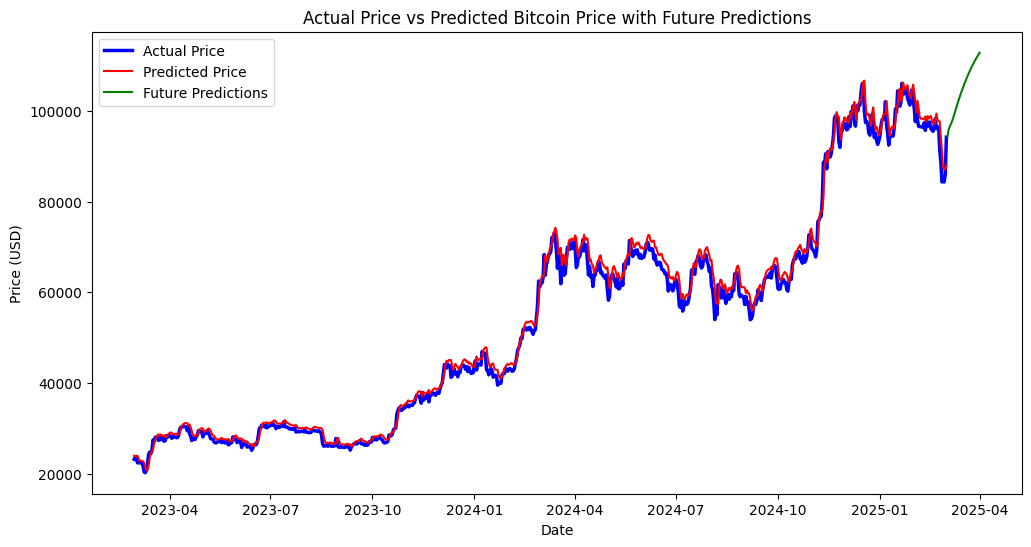

In [17]:
plt.figure(figsize=(12, 6))

plt.plot(df.index[-len(y_test_scaled):], y_test_scaled, label='Actual Price', color='blue', linewidth=2.5)
plt.plot(df.index[-len(y_test_scaled):], predictions, label='Predicted Price', color='red', linewidth=1.5)
plt.plot(future_dates, future_predictions, label='Future Predictions', color='green', linewidth=1.5)

plt.title('Actual Price vs Predicted Bitcoin Price with Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()

plt.show()

In [18]:
future_predictions_df = pd.DataFrame({'Date': future_dates, 'Predicted Price': future_predictions})
future_predictions_df

,Date,Predicted Price
0,2025-03-03 00:00:00+00:00,94409.945312
1,2025-03-04 00:00:00+00:00,95916.039062
2,2025-03-05 00:00:00+00:00,96590.578125
3,2025-03-06 00:00:00+00:00,97103.523438
4,2025-03-07 00:00:00+00:00,97689.789062
5,2025-03-08 00:00:00+00:00,98391.781250
6,2025-03-09 00:00:00+00:00,99177.984375
7,2025-03-10 00:00:00+00:00,100000.929688
8,2025-03-11 00:00:00+00:00,100823.039062
9,2025-03-12 00:00:00+00:00,101623.210938
